In [6]:
import textacy.io
import textacy
import textacy.keyterms
import textacy.datasets
import pandas as pd
import numpy as np
import spacy
import sys

Создаю  nlp для русского языка и добавляю  "наши" стоп-слова( ru2 взял с репозитория @buriy)

In [7]:
sys.path.append('/home/midzay/Mlerning/GitHUb/topic_news/spacy-ru/')

In [8]:
import ru2.lemmatizer

In [9]:
nlp=ru2.Russian2()

In [10]:
from nltk.corpus import stopwords

In [11]:
stop_words = stopwords.words('russian')
STOPLIST = set(stop_words)
with open('stopwords.txt') as sw:
    text =sw.read().splitlines()
for t in text:
    STOPLIST.add(t)
STOPLIST.add('—')


In [12]:
for w in STOPLIST:
    nlp.vocab[w].is_stop=True

In [13]:
type(nlp)

ru2.Russian2

Хотелось посмотреть какие получатся темы, если от начала и до конца использовать textacy. Поэтому в первой части мы берем настоящий текст новости, лемматизируем его средствами textacy  и строим темы. Во второй части - берем ранее лемматизированный текст(pymorphy2) и строим темы на нем.

In [14]:
PATH = '../../../../Mlerning/DATASET/proj_news_viz/small/'

In [47]:

data = pd.read_csv(PATH+'lemma/Sil_struktur.csv.bz2',usecols =['url','text','text_lema'])

In [51]:
data.head()

,url,text,text_lema
0,https://lenta.ru/news/1999/10/01/skuratov/,Генеральная прокуратура продлила еще на 4 меся...,генеральный прокуратура продлить 4 месяцасрок ...
1,https://lenta.ru/news/1999/10/04/bank_skandal/,Зять президента Ельцина Леонид Дьяченко вызван...,зять ельцин леонид дьяченко вызвать допрос бол...
2,https://lenta.ru/news/1999/10/04/chechnya/,По заявлению командующего объединенной федерал...,заявление командующий объединить федеральный г...
3,https://lenta.ru/news/1999/10/06/samara_vaz/,"Директор фирмы ""Эверест"" и его жена погибли в ...",директор фирма эверест жена погибнуть сильный ...
4,https://lenta.ru/news/1999/10/07/baturina/,Жена московского мэра Елена Батурина обратилас...,жена московский мэр елена батурин обратиться ж...


In [48]:
data.shape

(31361, 3)

### Часть I

Text Preprocessing



Обрабатываем настоящую новость

In [49]:
#   Приводим к нижнему регистру и лемматизируем.
def pre_processing(x):
    doc = textacy.preprocess.preprocess_text(str(x),lowercase=True)  
    doc = list(textacy.doc.Doc(doc,lang=nlp).to_terms_list(ngrams=(1), named_entities=True,
                                                           as_strings=True,normalize='lemma'))
    return doc

In [50]:
%%time
data_text = data[['text']]
data_text = data_text.loc[:,'text'].apply(pre_processing)

CPU times: user 48min 4s, sys: 4.52 s, total: 48min 8s
Wall time: 48min 17s


In [72]:
data_text.to_csv('silov_lemma_spacy.csv', index=False)

In [52]:
data_text.sample()

11570    [начальник, северо, западный, управление, спец...
Name: text, dtype: object

In [ ]:
# необходимо удалить все знаки пунктуации после лемматизации и все лишние символы

In [54]:
doc = [textacy.preprocess.preprocess_text(str(doc),lowercase=True,no_emails=True,no_phone_numbers=True,
                                      no_numbers=True,no_punct=True,) for doc in data_text.values]

In [56]:
len(doc),data_text.shape

(31361, (31361,))

In [59]:
doc[1][:300]

'зять президент ельцин леонид дьяченко вызвать допрос большим жюри нью йорк number октябрь писать газета ведомость американский власть подозревать фирма belka trading учредитель являться дьяченко уклонение уплата налог утверждать газета повестка получить жить сша генеральный директор компания виктор '

Создаем Corpus из  всех документов. затем будем 

In [73]:
%%time
corpus_text = textacy.Corpus(nlp, texts=doc)

CPU times: user 4min 9s, sys: 999 ms, total: 4min 10s
Wall time: 4min 11s


In [75]:
corpus_text[1]

Doc(175 tokens; "зять президент ельцин леонид дьяченко вызвать д...")

In [76]:
%%time
vectorizer = textacy.Vectorizer(
    tf_type='linear', apply_idf=True, idf_type='smooth', norm='l2',
     min_df=20, max_df=0.95)
doc_term_matrix = vectorizer.fit_transform(
    (doc.to_terms_list(ngrams=1, as_strings=True,normalize=False)
      for doc in corpus_text))
print(repr(doc_term_matrix))

<31361x9969 sparse matrix of type '<class 'numpy.float64'>'
	with 2634285 stored elements in Compressed Sparse Row format>
CPU times: user 14.5 s, sys: 99.9 ms, total: 14.6 s
Wall time: 14.2 s


### 20  тем

In [83]:
model = textacy.TopicModel('nmf', n_topics=20)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

(31361, 20)

In [84]:
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
     print('topic', topic_idx, ':', '   '.join(top_terms))

topic 0 : мвд   начальник   внутренний   управление   служба   дел   сотрудник   россия   генерал   заместитель
topic 1 : боевик   чечня   район   спецоперация   уничтожить   дагестан   операция   республика   ход   дом
topic 2 : летний   мужчина   женщина   квартира   задержать   тело   ребёнок   житель   обнаружить   девочка
topic 3 : адвокат   обвинять   дела   решение   суда   арест   обвинение   мосгорсуд   следствие   ходатайство
topic 4 : рубль   миллион   хищение   сумма   банка   миллиард   мошенничество   деньга   средство   фирма
topic 5 : колония   приговорить   приговор   свобода   лишение   виновный   режим   лет   наказание   признать
topic 6 : фсб   россия   российский   террористический   спецслужба   гражданин   задержать   украина   территория   государство
topic 7 : взрыв   теракт   устройство   взрывной   бомба   террорист   самодельный   смертник   мощность   погибнуть
topic 8 : статья   уголовный   рф   ук   возбудить   следственный   прокуратура   части   комите

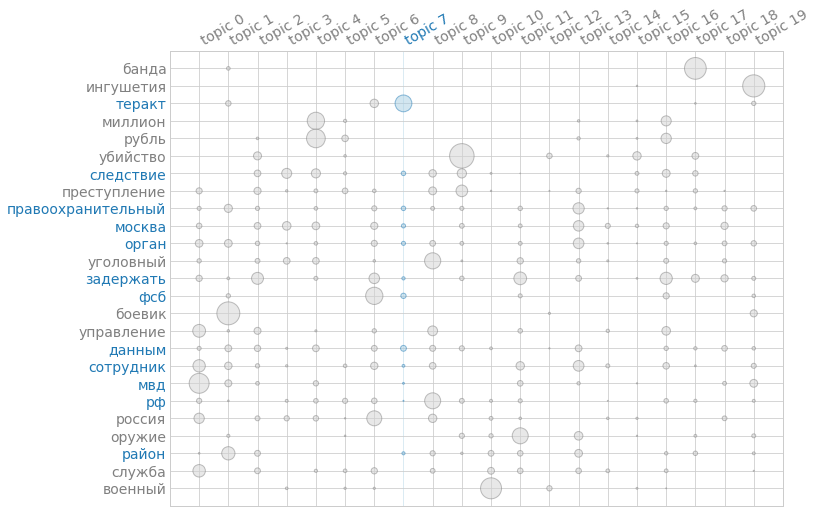

In [85]:
model.termite_plot(doc_term_matrix, vectorizer.id_to_term,

                   topics=-1,  n_terms=25, sort_terms_by='seriation',highlight_topics=7)

###   10 тем

In [86]:
%%time
model = textacy.TopicModel('nmf', n_topics=10)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

CPU times: user 1min 58s, sys: 100 ms, total: 1min 58s
Wall time: 41 s


In [78]:
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
     print('topic', topic_idx, ':', '   '.join(top_terms))

topic 0 : управление   следственный   уголовный   рф   начальник   статья   комитет   мвд   возбудить   сотрудник
topic 1 : боевик   чечня   район   спецоперация   уничтожить   дагестан   операция   республика   ингушетия   ход
topic 2 : преступник   нападение   автомобиль   скрыться   неизвестный   сотрудник   правоохранительный   место   улица   оружие
topic 3 : адвокат   юкос   обвинять   генпрокуратура   решение   дела   обвинение   суда   арест   мосгорсуд
topic 4 : рубль   миллион   сумма   деньга   тысяча   хищение   мошенничество   размер   миллиард   банка
topic 5 : колония   приговорить   приговор   свобода   лишение   виновный   лет   режим   наказание   признать
topic 6 : задержать   россия   фсб   изъять   преступный   мвд   сотрудник   гражданин   группировка   москва
topic 7 : взрыв   теракт   устройство   взрывной   бомба   террорист   самодельный   смертник   мощность   фсб
topic 8 : убийство   летний   мужчина   женщина   тело   преступление   квартира   ребёнок   зад

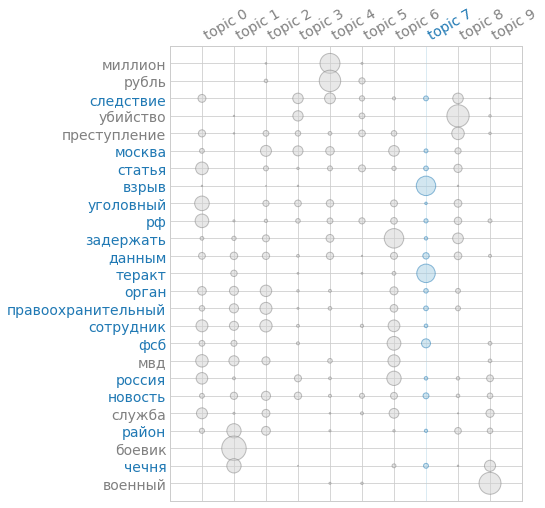

In [82]:
model.termite_plot(doc_term_matrix, vectorizer.id_to_term,

                   topics=-1,  n_terms=25, sort_terms_by='seriation',highlight_topics=7)
#  топик  7 выделил для примера, чтоб показать возможности termite_plot. 

###  Для примера еще построим несколько тем с разными параметрами model
параметры :model = 'lda',  n_topics =10

In [88]:
%time
model = textacy.TopicModel('lda', n_components=10)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/home/midzay/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


(31361, 10)

In [ ]:
# на самом деле  процесс проходил намного дольше)

In [89]:
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
     print('topic', topic_idx, ':', '   '.join(top_terms))

topic 0 : боевик   чечня   теракт   дагестан   район   республика   ингушетия   спецоперация   мвд   террористический
topic 1 : буданов   ростовский   болельщик   украинский   кунгаев   вырасти   предотвращение   лётчица   пересечь   черкесов
topic 2 : крым   взгляд   купюра   сугробова   битцевский   ислами   собутыльник   меджлис   работодатель   курортный
topic 3 : захарченко   самолёт   борт   воздушный   судна   катастрофа   экипаж   останки   судно   корабль
topic 4 : вор   авторитет   криминальный   калашов   ресторан   кличка   быков   известный   прайм   струганов
topic 5 : задержать   мужчина   летний   убийство   сотрудник   полицейский   москва   уголовный   произойти   возбудить
topic 6 : рубль   миллион   миллиард   хищение   банка   средство   сумма   фирма   мошенничество   деньга
topic 7 : фсин   чубайс   трепашкин   литвиненко   роснано   старовойтов   квачкова   сутягин   квачков   моисеев
topic 8 : кладбище   латвия   тамара   audi   рыно   скачевский   анохин   мог

###  model = 'lsa',  n_topics =10

In [90]:
%time
model = textacy.TopicModel('lsa', n_components=10)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


(31361, 10)

In [91]:
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
     print('topic', topic_idx, ':', '   '.join(top_terms))

topic 0 : задержать   убийство   сотрудник   уголовный   мвд   рубль   россия   москва   следствие   боевик
topic 1 : боевик   район   чечня   спецоперация   дагестан   уничтожить   ингушетия   республика   операция   правоохранительный
topic 2 : убийство   мужчина   летний   преступник   женщина   улица   место   тело   произойти   автомобиль
topic 3 : убийство   приговор   адвокат   присяжный   приговорить   колония   свобода   признать   виновный   лишение
topic 4 : рубль   миллион   боевик   преступник   тысяча   колония   деньга   приговорить   похитить   приговор
topic 5 : колония   теракт   задержать   приговорить   лишение   свобода   устройство   взрыв   фсб   взрывной
topic 6 : теракт   задержать   москва   взрыв   устройство   взрывной   убийство   банда   фсб   преступный
topic 7 : взрыв   устройство   взрывной   произойти   теракт   автомобиль   адвокат   бомба   суда   неизвестный
topic 8 : мвд   начальник   сотрудник   милиция   военный   внутренний   преступник   служба

In [108]:
# Можно посмотреть с каким весом  каждый документ относится к определенной теме

In [102]:
for doc_idx, topics in model.top_doc_topics(doc_topic_matrix, docs=range(10), weights=True, top_n=2):
        print(corpus_text[doc_idx], ':', topics)

Doc(75 tokens; "генеральный прокуратура продлить number месяцас...") : ((0, 0.12275344160894841), (7, 0.021099578240472233))
Doc(175 tokens; "зять президент ельцин леонид дьяченко вызвать д...") : ((0, 0.10784154838144076), (6, 0.05702228067945183))
Doc(149 tokens; "заявление командующего объединить федеральный г...") : ((1, 0.2059640484103323), (0, 0.17096704940932037))
Doc(76 tokens; "директор фирма эверест жена погибнуть результат...") : ((0, 0.1688954040630268), (2, 0.0853431289524487))
Doc(106 tokens; "жена московский мэр елена батурин обратиться жа...") : ((0, 0.1205263502876785), (6, 0.037839256544334815))
Doc(50 tokens; "number тысяча рубль дневной выручка похитить ре...") : ((0, 0.09777651979531385), (4, 0.08731604188993579))
Doc(73 tokens; "конец год пройти второй этап операция контроль ...") : ((0, 0.12885850453816478), (8, 0.09372494118415824))
Doc(82 tokens; "среда сотрудник управление борьба экономический...") : ((0, 0.2063912321966687), (6, 0.07166203334559379))
Doc(126 

## Часть II

Строим темы из текста, лематизированного pymorphy2 

In [103]:
doc = [textacy.preprocess.preprocess_text(str(doc)) for doc in data.text_lema.values]

In [105]:
len(doc),data.text_lema.shape

(31361, (31361,))

In [106]:
doc[1][:300]

'зять ельцин леонид дьяченко вызвать допрос больший жюри нью-йорк 14 писать газета ведомость американский власть подозревать фирма belka trading учредитель дьяченко уклонение уплата налог утверждать газета повестка жить сша генеральный директор виктор холенко интерес belka trading возникнуть глава ba'

видно что тексты лемматизированные spacy и pymorphy2  немного отличаются. Дальше делаем тоже самое

In [107]:
%%time
corpus_text = textacy.Corpus(nlp, texts=doc)

CPU times: user 4min 1s, sys: 1.15 s, total: 4min 2s
Wall time: 4min 4s


In [109]:
%%time
vectorizer = textacy.Vectorizer(
    tf_type='linear', apply_idf=True, idf_type='smooth', norm='l2',
     min_df=20, max_df=0.95)
doc_term_matrix = vectorizer.fit_transform(
    (doc.to_terms_list(ngrams=1, as_strings=True,normalize=False)
      for doc in corpus_text))
print(repr(doc_term_matrix))

<31361x9699 sparse matrix of type '<class 'numpy.float64'>'
	with 2725891 stored elements in Compressed Sparse Row format>
CPU times: user 14.6 s, sys: 47.9 ms, total: 14.6 s
Wall time: 14.4 s


In [110]:
%%time
model = textacy.TopicModel('nmf', n_topics=10)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

CPU times: user 1min 59s, sys: 146 ms, total: 1min 59s
Wall time: 45.5 s


In [115]:
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
     print('topic', topic_idx, ':', '   '.join(top_terms))

topic 0 : россия   управление   мвд   следственный   уголовный   служба   рф   прокуратура   начальник   проверка
topic 1 : боевик   чечня   район   спецоперация   уничтожить   дагестан   операция   республика   убитый   ингушетия
topic 2 : преступник   нападение   автомобиль   скрыться   машина   неизвестный   сотрудник   правоохранительный   место   улица
topic 3 : адвокат   обвинять   юкос   обвинение   бывший   генпрокуратура   решение   арест   мосгорсуд   убийство
topic 4 : рубль   миллион   банка   хищение   сумма   мошенничество   миллиард   деньга   средство   фирма
topic 5 : колония   приговорить   приговор   свобода   лишение   осудить   виновный   режим   наказание   признать
topic 6 : задержать   наркотик   изъять   преступный   оружие   группировка   сотрудник   незаконный   банда   килограмм
topic 7 : взрыв   теракт   устройство   взрывной   бомба   террорист   фсб   самодельный   террористический   смертник
topic 8 : убийство   мужчина   подозревать   женщина   тело   п

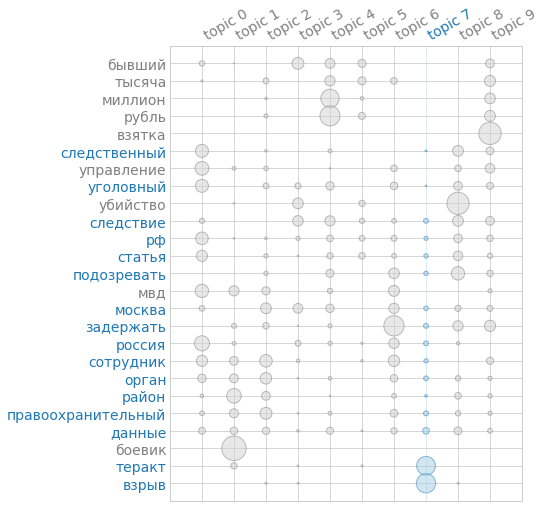

In [112]:
model.termite_plot(doc_term_matrix, vectorizer.id_to_term,

                   topics=-1,  n_terms=25, sort_terms_by='seriation',highlight_topics=7)

### Примеры тем, полученных разным способом

Темы полученные из текста лемматизированного ru2.Russian2

    topic 0 : управление   следственный   уголовный   рф   начальник   статья   комитет   мвд   возбудить   сотрудник
    topic 1 : боевик   чечня   район   спецоперация   уничтожить   дагестан   операция   республика   ингушетия   ход
    topic 2 : преступник   нападение   автомобиль   скрыться   неизвестный   сотрудник   правоохранительный   место   улица   оружие
    topic 3 : адвокат   юкос   обвинять   генпрокуратура   решение   дела   обвинение   суда   арест   мосгорсуд
    topic 4 : рубль   миллион   сумма   деньга   тысяча   хищение   мошенничество   размер   миллиард   банка
    topic 5 : колония   приговорить   приговор   свобода   лишение   виновный   лет   режим   наказание   признать
    topic 6 : задержать   россия   фсб   изъять   преступный   мвд   сотрудник   гражданин   группировка   москва
    topic 7 : взрыв   теракт   устройство   взрывной   бомба   террорист   самодельный   смертник   мощность   фсб
    topic 8 : убийство   летний   мужчина   женщина   тело   преступление   квартира   ребёнок   задержать   следствие
    topic 9 : военный   военнослужащий   буданов   войско   чечня   полковник   минобороны   генерал   внутренний   офицер


Темы полученные из текста лемматизированного pymorphy2

    topic 0 : россия   управление   мвд   следственный   уголовный   служба   рф   прокуратура   начальник   проверка
    topic 1 : боевик   чечня   район   спецоперация   уничтожить   дагестан   операция   республика   убитый   ингушетия
    topic 2 : преступник   нападение   автомобиль   скрыться   машина   неизвестный   сотрудник   правоохранительный   место   улица
    topic 3 : адвокат   обвинять   юкос   обвинение   бывший   генпрокуратура   решение   арест   мосгорсуд   убийство
    topic 4 : рубль   миллион   банка   хищение   сумма   мошенничество   миллиард   деньга   средство   фирма
    topic 5 : колония   приговорить   приговор   свобода   лишение   осудить   виновный   режим   наказание   признать
    topic 6 : задержать   наркотик   изъять   преступный   оружие   группировка   сотрудник   незаконный   банда   килограмм
    topic 7 : взрыв   теракт   устройство   взрывной   бомба   террорист   фсб   самодельный   террористический   смертник
    topic 8 : убийство   мужчина   подозревать   женщина   тело   преступление   дом   квартира   следствие   следственный
    topic 9 : взятка   получение   размер   задержать   тысяча   рубль   миллион   чиновник   доллар   управление
